In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-images/manzara.jpeg
/kaggle/input/sample-images/me.jpeg
/kaggle/input/sample-images/monet.jpeg


# Import Libraries

In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from PIL import Image 
import torchvision.transforms as transforms 
import torchvision.models as models 
from torchvision.utils import save_image  
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# VGG19 

In [3]:
model = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Feature Extraction

Get conv layers after max pooling and first conv layers. Since, these layers are good for feature extraction.  
Therefore, we want these 0. 5. 10. 19. 28. conv layers.

In [5]:
conv_layers = ['0','5','10','19','28']

We have extracted features of layers that named conv_layers.  
Thanks to these layers, we can detect object in the picture.   
We detect objects for protect objects.   
If we have house in the picture , we want to a house that combined with style image , don't want to lose house shape.

In [6]:
class VGG(nn.Module): 
    def __init__(self): 
        super(VGG,self).__init__() 
        
        self.chosen_features = conv_layers 
        self.model = models.vgg19(pretrained=True).features[:29] 
        
    def forward(self,x): 
        features = [] 
        
        for layer_num , layers in enumerate(self.model): 
            x = layers(x) 
            
            if str(layer_num) in self.chosen_features : 
                features.append(x) 
                
        return features 

# Loading Function

In [7]:
def load_image(image_name): 
    img = Image.open(image_name) 
    img = loader(img).unsqueeze(0) 
    return img.to(device)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu") 
image_size = 356 

In [9]:
loader = transforms.Compose(
[
   transforms.Resize((image_size,image_size)),
   transforms.ToTensor()
   #transform.Normalize(mean[],std[])
]
)

# IMAGE LOADING

## Content Image

### Plot Content Image

In [10]:
content_img = load_image('/kaggle/input/sample-images/me.jpeg') 
print(type(content_img),'\nshape:',content_img.shape) 

<class 'torch.Tensor'> 
shape: torch.Size([1, 3, 356, 356])


Tensor to Numpy

In [11]:
tmp = np.transpose(content_img.cpu(),[2,3,1,0]).cpu().numpy()
print(tmp.shape)

(356, 356, 3, 1)


Numpy Reshape

In [12]:
tmp  = tmp.reshape((356,356,3)) 
tmp.shape

(356, 356, 3)

Plotting

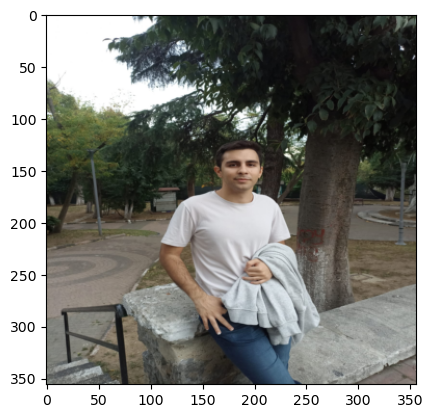

In [13]:
plt.imshow(tmp)  
plt.show()

## Style Image

In [14]:
style_img = load_image('/kaggle/input/sample-images/monet.jpeg')  
print(type(style_img),'\nshape:',style_img.shape) 

<class 'torch.Tensor'> 
shape: torch.Size([1, 3, 356, 356])


### Plot Style Image

Tensor to Numpy

In [15]:
tmp_style = np.transpose(style_img.cpu(),[2,3,1,0]).cpu().numpy()
print(tmp_style.shape)

(356, 356, 3, 1)


Rehsape Numpy array

In [16]:
tmp_style  = tmp_style.reshape((356,356,3)) 
tmp_style.shape

(356, 356, 3)

Plotting

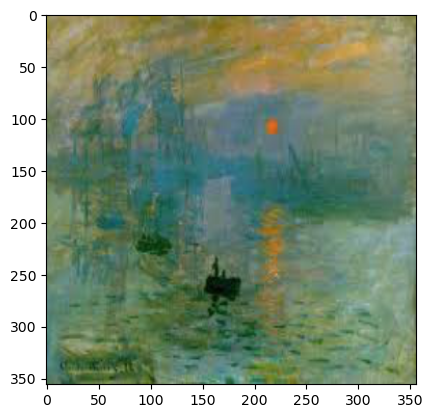

In [17]:
plt.imshow(tmp_style)  
plt.show()

## Content Image

In original paper, content image  initialized randomly. However, it will take too much time , if we did same.

In [18]:
combine = content_img.clone().requires_grad_(True)

# HyperParameters

You can change these hyperparameters for different results.

In [19]:
# Hyperparameters 
iter_num = 10000 
learning_rate = 0.001 
alpha = 0.9 
beta = 0.1 
optimizer = optim.Adam([combine],lr = learning_rate)

In [20]:
model = VGG().to(device).eval()

# TRAIN

I suggest if you train yourself with your picture, you should use Kaggle or Colab for GPU. It will take little time.

In [21]:
for step in range(iter_num): 
    combine_features = model(combine) 
    content_features = model(content_img) 
    style_features = model(style_img) 
    
    content_loss = 0. 
    style_loss = 0. 
    
    for com_feat , cont_feat , style_feat in zip(
        combine_features,content_features,style_features
    ): 
        batch_size, channel , height, width = com_feat.shape 
        content_loss += torch.mean((com_feat - cont_feat) ** 2) 
        
        # Compute gram matrix 
        Gram_com = com_feat.view(channel, height * width).mm(
            com_feat.view(channel,height * width).t()
        )
         
        Gram_style = style_feat.view(channel, height * width).mm(
            style_feat.view(channel,height * width).t()
        ) 
        
        style_loss += torch.mean((Gram_com - Gram_style) ** 2)
    
    
    total_loss = alpha * content_loss + beta * style_loss 
    optimizer.zero_grad() 
    total_loss.backward() 
    optimizer.step() 
    
    if step % 500 == 0: 
        print(total_loss)  
    

tensor(2899147.7500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30437.5625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13535.6445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8543.0488, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5972.2451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4293.4443, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3083.3127, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2193.3440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1560.8638, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1129.4962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(406.7390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(335.2243, device='cuda:0', grad_fn=<AddBackward0>)
tensor(284.2231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(246.2433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(220.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(271.7758, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.1103, device='cuda:0', grad_fn=<AddBackward0>)

# SAVE IMAGE

In [22]:
save_image(combine,'combine_last.jpeg')

# COMBINE IMAGE

In [23]:
combine.shape

torch.Size([1, 3, 356, 356])

Tensor to Numpy

In [24]:
tmp_combine = np.transpose(combine.cpu().detach().numpy(),[2,3,1,0]) 
print(type(tmp_combine) ,'\nshape:',tmp_combine.shape)

<class 'numpy.ndarray'> 
shape: (356, 356, 3, 1)


Reshape

In [25]:
tmp_combine  = tmp_combine.reshape((356,356,3)) 
tmp_combine.shape

(356, 356, 3)

# Final Result

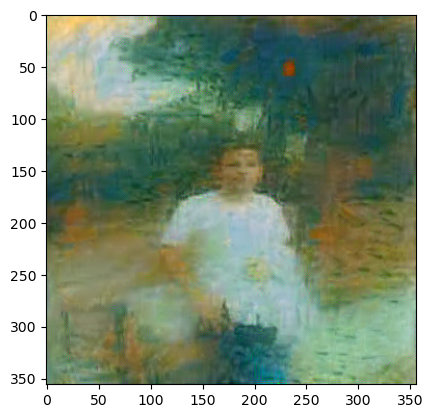

In [26]:
plt.imshow(tmp_combine)  
plt.show()